In [86]:
!pip install Arabic-Stopwords
!pip install pyLDAvis
!pip install wordcloud
!pip install arabic-reshaper


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [87]:
import pandas as pd
import numpy as np
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from urllib.parse import urlsplit
import itertools
import ast

pd.set_option('display.max_colwidth', 100)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF,LatentDirichletAllocation
import pyLDAvis #Nous utilisons pyLDAvis pour créer des visualisations interactives de modèles de sujet.

pyLDAvis.enable_notebook()

from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim import corpora
from gensim.utils import simple_preprocess
import gensim
from nltk.corpus import stopwords
import nltk
import re
import logging
import string
import arabic_reshaper
import arabicstopwords.arabicstopwords as stp
#import arabicstopwords.arabicstopwords as stp
#from farasa.stemmer import FarasaStemmer

In [88]:


arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)



def remove_urls(text):
    """removing unnecessary white spaces

    Parameters
    ----------
    text : str
        plain text.

    Returns
    -------
    str
        s
    """
    return re.sub(r':.*$', ":", str(text))

def number_remover(text):
    """removing numbers from text

    Parameters
    ----------
    text : str
        plain text.

    Returns
    -------
    str
        same input text but cleaned from numbers
    """
    result = re.sub(r"\d+", "", text)
    return result

def remove_white_spaces(text):
    """removing unnecessary white spaces

    Parameters
    ----------
    text : str
        plain text.

    Returns
    -------
    str
        same input text but unnecessary white spaces
    """
    return re.sub(' +', ' ', text)




def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_non_arabic(text):
    text = re.findall(r'[\u0600-\u06FF]+',text)
    text = [word for word in text if len(word)>1]
    text = ' '.join(text)
    return(text)


#Tokenization
def tokenize_text(corpus):
    tokensCorpus=[]
    for doc in corpus:
        doc_tokens = word_tokenize(doc)
        tokensCorpus.append(doc_tokens)
    return tokensCorpus

#recuperer les mots qui apparaissent dans plusieurs documents
def get_mostCommonWords(corpus,max_freq=100):
    vocabulaire=dict() #dictionnaire qui va contenir le nombre d'occurence des mots dans les documents
    for doc in corpus:
        for word in set(doc.split()): #recupere les mots unique de chaque documents
            if word in vocabulaire:
                vocabulaire[word]+=1
            else:
                vocabulaire[word]=1
    
    #recupere les dont le nombre d'occurences dans les documents > max_freq
    mostCommonsWord=[word for word,value in vocabulaire.items() if value>max_freq ]
        
    return mostCommonsWord


# removing stopwords
def remove_stopwords(corpus,mostCommonsWord=[]):
    filtered_corpus=[]
    for tokens in corpus:
        #others_sw=["المغرب","شكرا","الصحافه","مغاربه","الي","اخر","علي","اليوم","ساعه","الساعه","والتفاصيل","خلال","تسجيل","والتفاصيل","لمزيد","الارقام","العد","حتي","بسب","الا","باش","بفيروس"
                  #,"المغربيه","المغاربه","بفيروس","بالمغرب","حالات","تعلن","الهم","الوباءيه","يسجل","الاصابات","بكورونا","الحاله","جديده","الاجمالي","الاجمالي","حصيله","اول","قبل","يوم","زمن","مءكده",
                   #"الدار","البيضاء","بلادك","واحد","المغربي","الحالات","حول","وفيات","وباء","حول","انا","مساء","هاد","الجديده","الفيروس","ديال","كان","الصحي","الجديد","الملكه","عاجل","فدارك"
                   #,"الصحيه","تحمي","اله","الصحه","خليك","امام","بقا","محمد","كورونا","هادي"]
        
        #french_sw = stopwords.words('french') 
        arabic_sw=list(set(stopwords.words("arabic"))) 
        #arabic_sw.extend(others_sw)
        arabic_sw.extend(list(stp.stopwords_list()))
        arabic_sw.extend(mostCommonsWord)
        
        filtered_tokens = [token for token in tokens.split() if token not in arabic_sw and len(token)>3]
        filtred_text=' '.join(filtered_tokens) #reforme le text du documents separé par espace
        filtered_corpus.append(filtred_text)
    return filtered_corpus

def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=2, threshold=10) # higher threshold fewer phrases
    # Un moyen plus rapide d'obtenir une phrase matraquée comme un trigramme / bigramme
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    corpus_bigram=[" ".join(bigram_mod[doc]) for doc in texts]
    return corpus_bigram

def is_topic(document, category_words, min_freq=2):
    document = document.split(" ")
    intersection = list(set(document) & set(category_words))
    if(len(intersection)>=min_freq):
        return(True)
    else:
        return(False)


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

df = pd.read_excel('datasets.xlsx')
df['cleaned_comment'] = df['cleaned_comment'].fillna('')  # fill missing values with empty string

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df['cleaned_comment'])
tfidf_matrix = tfidf_vectorizer.transform(df['cleaned_comment'])
tfidf_array = tfidf_matrix.toarray()

print(tfidf_matrix)


  (0, 4051)	1.0
  (1, 4051)	1.0
  (2, 4051)	1.0
  (3, 2116)	0.1808766964639688
  (3, 2585)	0.21435041186583487
  (3, 2603)	0.1505584039679889
  (3, 2860)	0.2740196071151826
  (3, 3306)	0.32643837008746057
  (3, 3410)	0.45615242561758707
  (3, 5828)	0.08695864537517228
  (3, 6111)	0.18047275884201708
  (3, 6159)	0.20002891958563848
  (3, 7280)	0.20951221593850192
  (3, 8130)	0.21136967783936728
  (3, 8342)	0.26442967951492363
  (3, 9327)	0.15143894353952211
  (3, 12557)	0.20144487098284952
  (3, 12575)	0.24181820034889723
  (3, 12612)	0.24924091295547493
  (3, 12740)	0.1808766964639688
  (3, 12972)	0.23125591636107112
  (4, 1376)	0.18787318555800697
  (4, 1630)	0.239738350340863
  (4, 1663)	0.27693112809163145
  (4, 2076)	0.1534404269028898
  :	:
  (10197, 8176)	0.5036078853793098
  (10197, 9373)	0.24637418217734947
  (10197, 11443)	0.24885959020397772
  (10198, 5647)	0.7318603493210355
  (10198, 6826)	0.6814546419914476
  (10199, 1559)	0.22862128585236843
  (10199, 1916)	0.176355131844

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load the cleaned comments and their corresponding labels
df = pd.read_excel('1700clean.xlsx')
comments = df['cleaned_comment']
labels = df['Avis']  # Replace 'sentiment' with the actual column name containing sentiment labels
df2 = pd.read_excel('datasets.xlsx')
comments_ = df2['cleaned_comment']

# Replace missing values with empty strings
comments = comments.replace(np.nan, '', regex=True)

# Split the dataset into training and testing sets
train_comments, test_comments, train_labels, test_labels = train_test_split(comments, labels, test_size=0.2, random_state=50)

# Create an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training comments
train_tfidf = tfidf_vectorizer.fit_transform(train_comments)

# Transform the testing comments
test_tfidf = tfidf_vectorizer.transform(test_comments)

# Choose the SVM algorithm (SVC)
model = SVC()

# Perform cross-validation
cv_scores = cross_val_score(model, train_tfidf, train_labels, cv=5)  # 5-fold cross-validation

# Train the model
model.fit(train_tfidf, train_labels)

# Make predictions on the testing set
predictions = model.predict(test_tfidf)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

# Print the cross-validation scores and evaluation metrics
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Make predictions on the comments in df2
tfidf_matrix = tfidf_vectorizer.transform(comments_)
predictions = model.predict(tfidf_matrix)

# Create a new dataframe with the comments and their predicted labels
result_df = pd.DataFrame({'comment': comments_, 'label': predictions})



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Scores: [0.63397129 0.66267943 0.65947242 0.67146283 0.69304556]
Mean CV Accuracy: 0.6641263066102143
Accuracy: 0.710727969348659
Precision: 0.7099485890209947
Recall: 0.710727969348659
F1-Score: 0.7098565986427189


In [142]:
result_df

,comment,label
0,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,neutre
1,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم😍😍😍😍😍😍😍😍😍😍😍,neutre
2,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,neutre
3,جد اول شخص وسط فني كلم بكل ثقه ورق وهب تحس فخر عزز جد شرف بلد ورب وفق سعد,neutre
4,انه لغة حب حرم ليس وطن او عرق وكل اشع قيل سعد كله كذب حقر . ابن اسر طيب .. عرق مر,positive
...,...,...
10195,عئل غرب رقي حفل اطر عئل فقط .,neutre
10196,غيت تهل علم راه عزز وغل ولد بلد,negative
10197,الل كمل علي خير رفء بنن بين بنت ناس فرطش,positive
10198,زون طبع,negative


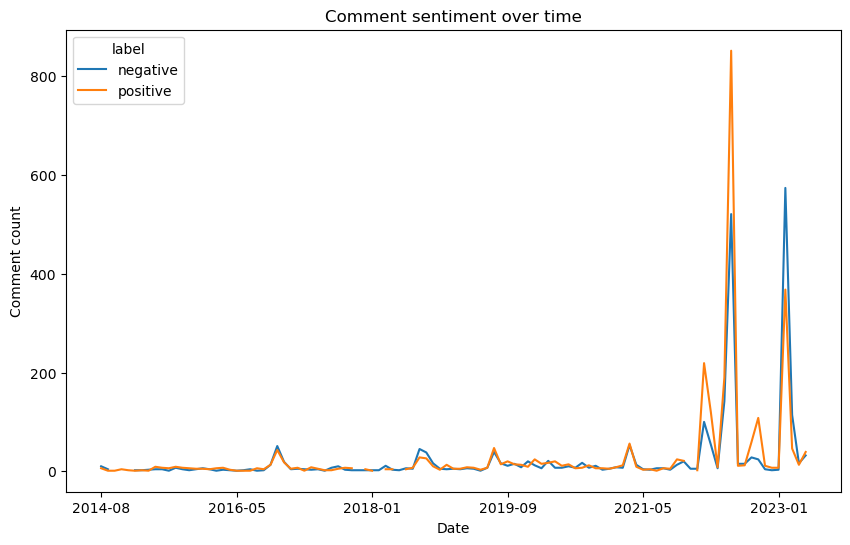

In [143]:
# Add a date column to the new dataframe
result_df['timestamp'] = pd.to_datetime(df2['timestamp']).dt.date
result_df['timestamp'] = pd.to_datetime(result_df['timestamp']).dt.strftime('%Y-%m')
# Group the comments by date and predicted label
result_df = result_df[result_df['label'] != 'neutre']
counts = result_df.groupby(['timestamp', 'label']).size().unstack()

# Plot the counts over time
counts.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Comment count')
plt.title('Comment sentiment over time')
plt.show()


In [144]:
result_df['timestamp'] = pd.to_datetime(df2['timestamp']).dt.date

C:\Users\huski\AppData\Local\Temp\ipykernel_14744\3406918699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['timestamp'] = pd.to_datetime(df2['timestamp']).dt.date


In [145]:
result_df['timestamp']

4        2022-11-09
5        2022-08-03
8        2022-06-30
9        2022-06-29
10       2022-06-27
            ...    
10194    2022-09-12
10196    2022-09-12
10197    2022-09-12
10198    2022-09-12
10199    2022-09-12
Name: timestamp, Length: 5235, dtype: object

In [24]:
!pip install tashaphyne



Defaulting to user installation because normal site-packages is not writeable


In [178]:
result_df = pd.read_excel('datasets.xlsx')

In [179]:
corpus = list(result_df["comment"])

In [180]:
text = " -|- ".join(tweet for tweet in corpus)

In [181]:
from tashaphyne.stemming import ArabicLightStemmer
ArListem = ArabicLightStemmer()


In [182]:
stemed_text = ArListem.light_stem(text)

In [183]:
stemmed_text = ArListem.get_root()

In [184]:
stemmed_text_list = stemed_text.split('-|-')

In [185]:
result_df["comment"] = stemmed_text_list

In [186]:
len(stemmed_text_list)

10200

In [187]:
most_commonWords = [']','[','!','بالله','والله','الله','اللهم', 'الابالله']

In [188]:
stemmed_text_list=remove_stopwords(stemmed_text_list, most_commonWords)

In [189]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Load comments from Excel file into a pandas DataFrame
# df = pd.read_excel('datasets.xlsx')
commentsX = result_df["comment"]

# Vectorize the preprocessed text data using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(commentsX)

# Apply K-means clustering algorithm
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Assign comments to their respective clusters
result_df['cluster'] = kmeans.predict(X)

# Analyze top keywords in each cluster to identify topics discussed in comments
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
vocab = vectorizer.vocabulary_

for i in range(4):
    print(f"\n\nTopic {i+1}:")
    top_keywords = [word for word in vocab if vocab[word] in order_centroids[i, :10]]
    print(', '.join(top_keywords))





Topic 1:
من, سعد, الله, ما, يا, لا, في, على, كل, ان


Topic 2:
من, سعد, الله, ما, يا, لا, في, انا, على, المجرد


Topic 3:
من, الله, لا, في, على, الذين, محمد, أن, العالمين, المهدي


Topic 4:
من, الله, ما, في, على, محمد, سلمان, المهدي, ناصر, اليماني


In [106]:
!pip install --upgrade scikit-learn
!pip install --upgrade numpy
!conda install -c conda-forge openblas


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.7 MB 6.7 MB/s eta 0:00:02
   ---------------------------------------- 8.7/8.7 MB 30.1 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   -------------- ------------------------- 4.7/12.8 MB 25.9 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 42.2 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.3 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.3 which is incompatible.


^C


In [190]:
result_df[result_df['cluster'] == 0]['cluster'] = 'T1'

C:\Users\huski\AppData\Local\Temp\ipykernel_14744\1619970958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[result_df['cluster'] == 0]['cluster'] = 'T1'


In [191]:
replacement_map = {0:'T1',1: 'T2', 2: 'T3', 3: 'T4', 4: 'T5', 5: 'T6'}

# Perform replacements using replace() method
result_df['cluster'] = result_df['cluster'].replace(replacement_map)

In [192]:
result_df

,timestamp,comment,cleaned_comment,cluster
0,2023-04-09T00:00:45Z,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,T2
1,2023-04-09T00:00:31Z,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم😍😍😍😍😍😍😍😍😍😍😍,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم😍😍😍😍😍😍😍😍😍😍😍,T2
2,2023-04-09T00:00:18Z,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,T2
3,2023-03-06T17:24:08Z,جد اول شخص من الوسط الفني يتكلم بكل ثقه ورقي وهيبه وبتحس بفخر واعتزاز جد بيشرف بلده وربي يوفقك...,جد اول شخص وسط فني كلم بكل ثقه ورق وهب تحس فخر عزز جد شرف بلد ورب وفق سعد,T2
4,2022-11-09T20:43:49Z,إنها لغة حب واحترام ليسه لها وطن او عرقا\nوكل إشاعات قيلت عن سعد كلها كذب حقير. ابن اسره طيبه.....,انه لغة حب حرم ليس وطن او عرق وكل اشع قيل سعد كله كذب حقر . ابن اسر طيب .. عرق مر,T2
...,...,...,...,...
10195,2022-09-12T20:14:10Z,العائلات المغربية الراقية هي من تحتفل في اطار عائلي فقط.,عئل غرب رقي حفل اطر عئل فقط .,T2
10196,2022-09-12T20:10:09Z,غيتة تهلاي في المعلم راه عزيز وغالي ولد بلادي,غيت تهل علم راه عزز وغل ولد بلد,T2
10197,2022-09-12T19:59:41Z,الله اكمل عليكم بالخير بالرفاء والبنين باينة بنت الناس متفرطش فيها,الل كمل علي خير رفء بنن بين بنت ناس فرطش,T2
10198,2022-09-12T19:56:12Z,زوينة طبيعية,زون طبع,T2


In [38]:
!pip install python-bidi


Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### word cloud network

In [193]:
import networkx as nx

In [194]:
from bidi.algorithm import get_display

In [195]:
def get_sub_dict(dict_, size=10):
    sub_dict = {}
    i = 0
    for key, values in dict_.items():
        i += 1
        sub_dict[key] = values
        if (i> size):
            break;
    return(sub_dict)

In [196]:
def get_tokens_tfd(text_list, nb_tokens = 10):
    total_tokens = []
    for text in stemmed_text_list:
        total_tokens += nltk.word_tokenize(text)
    #compute frequency distribution for all the bigrams in the text
    #Create your bigrams
    bgs = nltk.bigrams(total_tokens)
    fdist = nltk.FreqDist(bgs)

    fdist_sorted = dict(sorted(fdist.items(), key=lambda item: item[1], reverse = True))

    sub_dict = get_sub_dict(fdist_sorted, nb_tokens)
    keys_list = [list(tuple_) for tuple_ in list(sub_dict.keys())]
    top_20_tokens = [x for sublist in keys_list for x in sublist]
    top_20_tokens = list(set(top_20_tokens))
    top_20_tokens_dict = {i: top_20_tokens[i] for i in range(len(top_20_tokens))}
    tokens_tfd = np.zeros((len(top_20_tokens),len(stemmed_text_list)))
    i = 0
    for token in top_20_tokens:
        for j in range(len(stemmed_text_list)):
            if (token in list(stemmed_text_list)[j]) == True:
                tokens_tfd[i][j] = 1
        i +=1
    tokens_tfd = np.dot(tokens_tfd, tokens_tfd.T)
    return(tokens_tfd,top_20_tokens)

In [197]:
def plot_graph(topic,text, top_20_tokens = None, tokens_tfd = None):
    
    G = nx.Graph()
    for i in range(len(top_20_tokens)):
        reshaped_text_i = arabic_reshaper.reshape(top_20_tokens[i])
        artext_i = get_display(reshaped_text_i)
        for j in range(len(top_20_tokens)):
            if(i != j):
                reshaped_text_j = arabic_reshaper.reshape(top_20_tokens[j])
                artext_j = get_display(reshaped_text_j)
                G.add_edge(artext_i, artext_j, weight = int(tokens_tfd[i][j]))


    #return(0)
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    labels_dict = {(u,v):d['weight'] for (u, v, d) in G.edges(data=True) if d["weight"] > 0}
    #esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.circular_layout(G)  # positions for all nodes - seed for reproducibility

    # nodes
    fig = plt.figure(frameon=False)
    fig.set_size_inches(20,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color = "#A0CBE2")
    
    total_weights = np.sum(tokens_tfd)
    widths = [(d['weight']/total_weights)*200 for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=widths, edge_color = "#74898C")

    # labels
    nx.draw_networkx_labels(G, pos, font_size=50, font_color = "black");
    #nx.draw_networkx_edge_labels(G, pos, font_size=15, edge_labels=labels_dict, font_color = 'blue');
    #ax = plt.gca();
    ax.margins(0.08);

    #plt.axis("off");
    #plt.tight_layout();
    #plt.savefig(f'./plots/{topic}_wordcloud_network.png',transparent=True, pad_inches = 0 )
    plt.show()

In [198]:
topics = ['T1','T2','T3','T4']

In [199]:
result_df

,timestamp,comment,cleaned_comment,cluster
0,2023-04-09T00:00:45Z,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,T2
1,2023-04-09T00:00:31Z,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم😍😍😍😍😍😍😍😍😍😍😍,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم😍😍😍😍😍😍😍😍😍😍😍,T2
2,2023-04-09T00:00:18Z,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم حلم 😍😍😍😍😍😍😍😍😍😍😍,T2
3,2023-03-06T17:24:08Z,جد اول شخص من الوسط الفني يتكلم بكل ثقه ورقي وهيبه وبتحس بفخر واعتزاز جد بيشرف بلده وربي يوفقك...,جد اول شخص وسط فني كلم بكل ثقه ورق وهب تحس فخر عزز جد شرف بلد ورب وفق سعد,T2
4,2022-11-09T20:43:49Z,إنها لغة حب واحترام ليسه لها وطن او عرقا\nوكل إشاعات قيلت عن سعد كلها كذب حقير. ابن اسره طيبه.....,انه لغة حب حرم ليس وطن او عرق وكل اشع قيل سعد كله كذب حقر . ابن اسر طيب .. عرق مر,T2
...,...,...,...,...
10195,2022-09-12T20:14:10Z,العائلات المغربية الراقية هي من تحتفل في اطار عائلي فقط.,عئل غرب رقي حفل اطر عئل فقط .,T2
10196,2022-09-12T20:10:09Z,غيتة تهلاي في المعلم راه عزيز وغالي ولد بلادي,غيت تهل علم راه عزز وغل ولد بلد,T2
10197,2022-09-12T19:59:41Z,الله اكمل عليكم بالخير بالرفاء والبنين باينة بنت الناس متفرطش فيها,الل كمل علي خير رفء بنن بين بنت ناس فرطش,T2
10198,2022-09-12T19:56:12Z,زوينة طبيعية,زون طبع,T2


In [200]:
df_1 = result_df[result_df['cluster'] == 'T1']

In [201]:
df_1

,timestamp,comment,cleaned_comment,cluster
7,2022-07-05T18:28:26Z,نصيحة مني يا سعد لا تكون كا منافقين روح شوف الجزاءري ديدجي سنايك له اكتر من تلت كليبات في الواح...,نصح مني سعد تكون كا نفق روح شوف جزءر ديدج سني كتر تلت كلب وحد قرب لات لير شهد كذب تقل انا اول فن...,T1
10,2022-06-27T00:19:02Z,نتمنى يكون حلمك هو توب إلى الله يا سعد أتدري معنى اسم سعد في الدين في عهد النبي صلى الله عليه و...,منى يكون حلم توب الل سعد تدر عنى اسم سعد دين عهد نبي صلى الل سلم,T1
13,2022-06-21T23:16:37Z,لكل الحمقى المعلقين الذين يستعملون الله وما شاءالله استحو من الله. اهاكذا عالمنا رسول الله الغن...,لكل حمقى علق عمل الل شاءالل سحو الل . هكذ علم رسل الل غنء فسق جهر عصة .لل أخذ فعل فهء منا وصل له...,T1
19,2022-06-13T10:27:20Z,الاغا علم ان سعد لمجرد يغالب دموعه ولم يعد قادر على الكلام ، فما اجمل العناق حين يخفف و حين يكو...,اغا ان سعد جرد غلب دمع ولم يعد قدر كلم ، فما جمل عنق خفف يكون شخص يحب منى خير ، دمع سعد كانت سبب...,T1
23,2022-06-11T18:54:48Z,احلى برنامج ي الله على المشاعر الصادقة و الله ابن عائلة محترمة عندنا في المغرب اللهم ابعد الشر ...,حلى رنمج الل شعر صدق الل ابن عئل حرم عند غرب لهم بعد لشر علي الل جمع يدن قرب وقت نحب كتتتتتتتتير...,T1
...,...,...,...,...
10151,2022-09-17T16:39:09Z,#رسالة مستعجلة لكل المغاربة المرجو خوتي لعزاز تركزوا على هذا الموضوع بالضبط يريد ال.ي.ه.و.د ال....,# رسل عجل لكل غرب رجو خوت عزز ركز وضع ضبط يرد .ي.ه.و.د .ص.ه.ا.ي.ن.ة يتم هود هود هود شعب غرب يعن ...,T1
10165,2022-09-13T20:18:42Z,بساطة ملفتة لهذه الشابة و الله عجبتني لانها ليست من عالم التجميل و النفخ و الشفط و الميكاب و ا...,بسط لفت لهذ شبة الل عجب لان علم جمل نفخ شفط يكب عري الى فتة شبع تحة جزر الف برك عرس,T1
10168,2022-09-13T16:57:57Z,سلام.عليكم.اختكم.فاطم.تحياتنالي.للاسرة\nسعد.الله.اجعل.هدا.الجواج.كتير.من.المحب\nولله.احفضكم.وكم...,سلام.عليكم.اختكم.فاطم.تحياتنالي.للاسرة سعد.الله.اجعل.هدا.الجواج.كتير.من.المحب ه.احفضكم.وكمل.علكم...,T1
10174,2022-09-13T12:45:04Z,مشاء الله علا سعد لمجرد لمعلم الله يبارك لكم ومبروك عليكم غيتى يخلصها الله علا كل ما عملته م...,شاء الل علا سعد جرد علم الل يبر برو علي غيتى خلص الل علا عمل معك ههي نتج نتج الل صبر يعط يتو,T1


In [81]:
!pip install nltk
import nltk

Defaulting to user installation because normal site-packages is not writeable


topic: T1


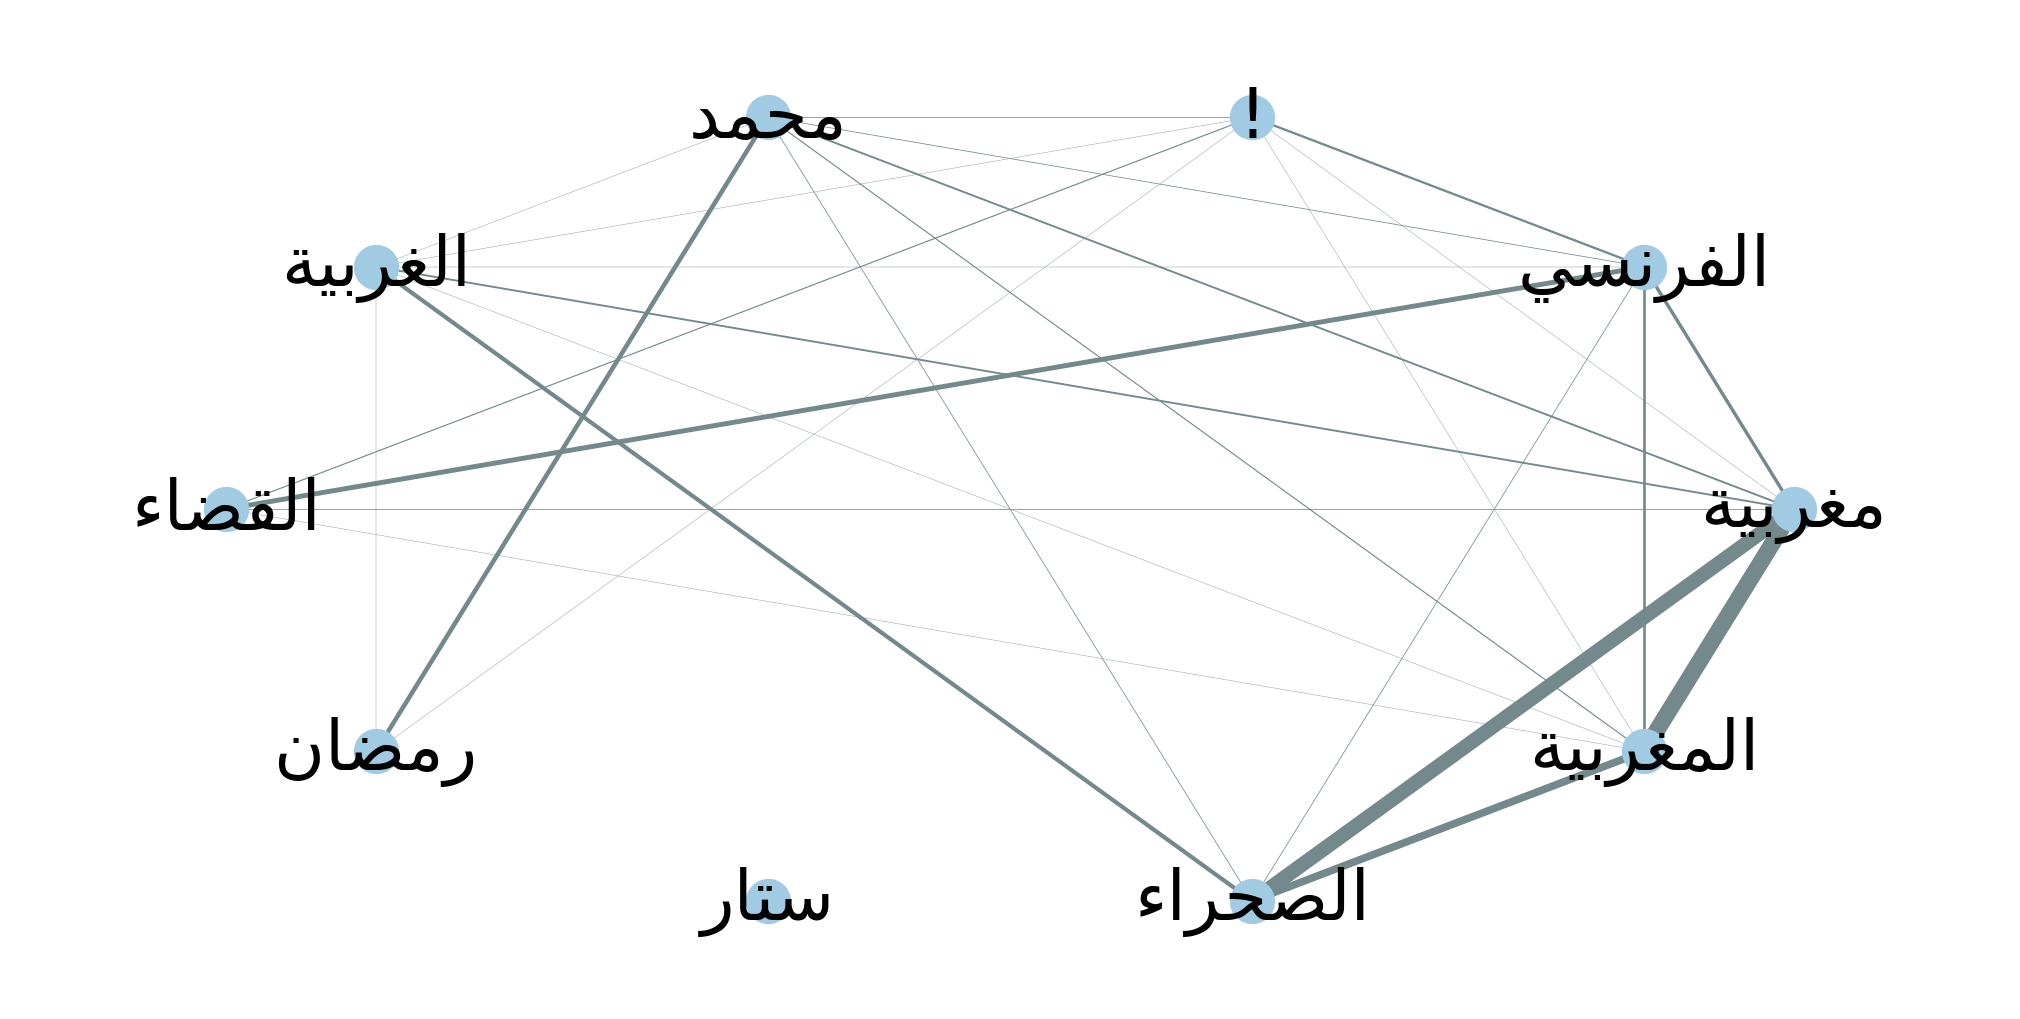

topic: T2


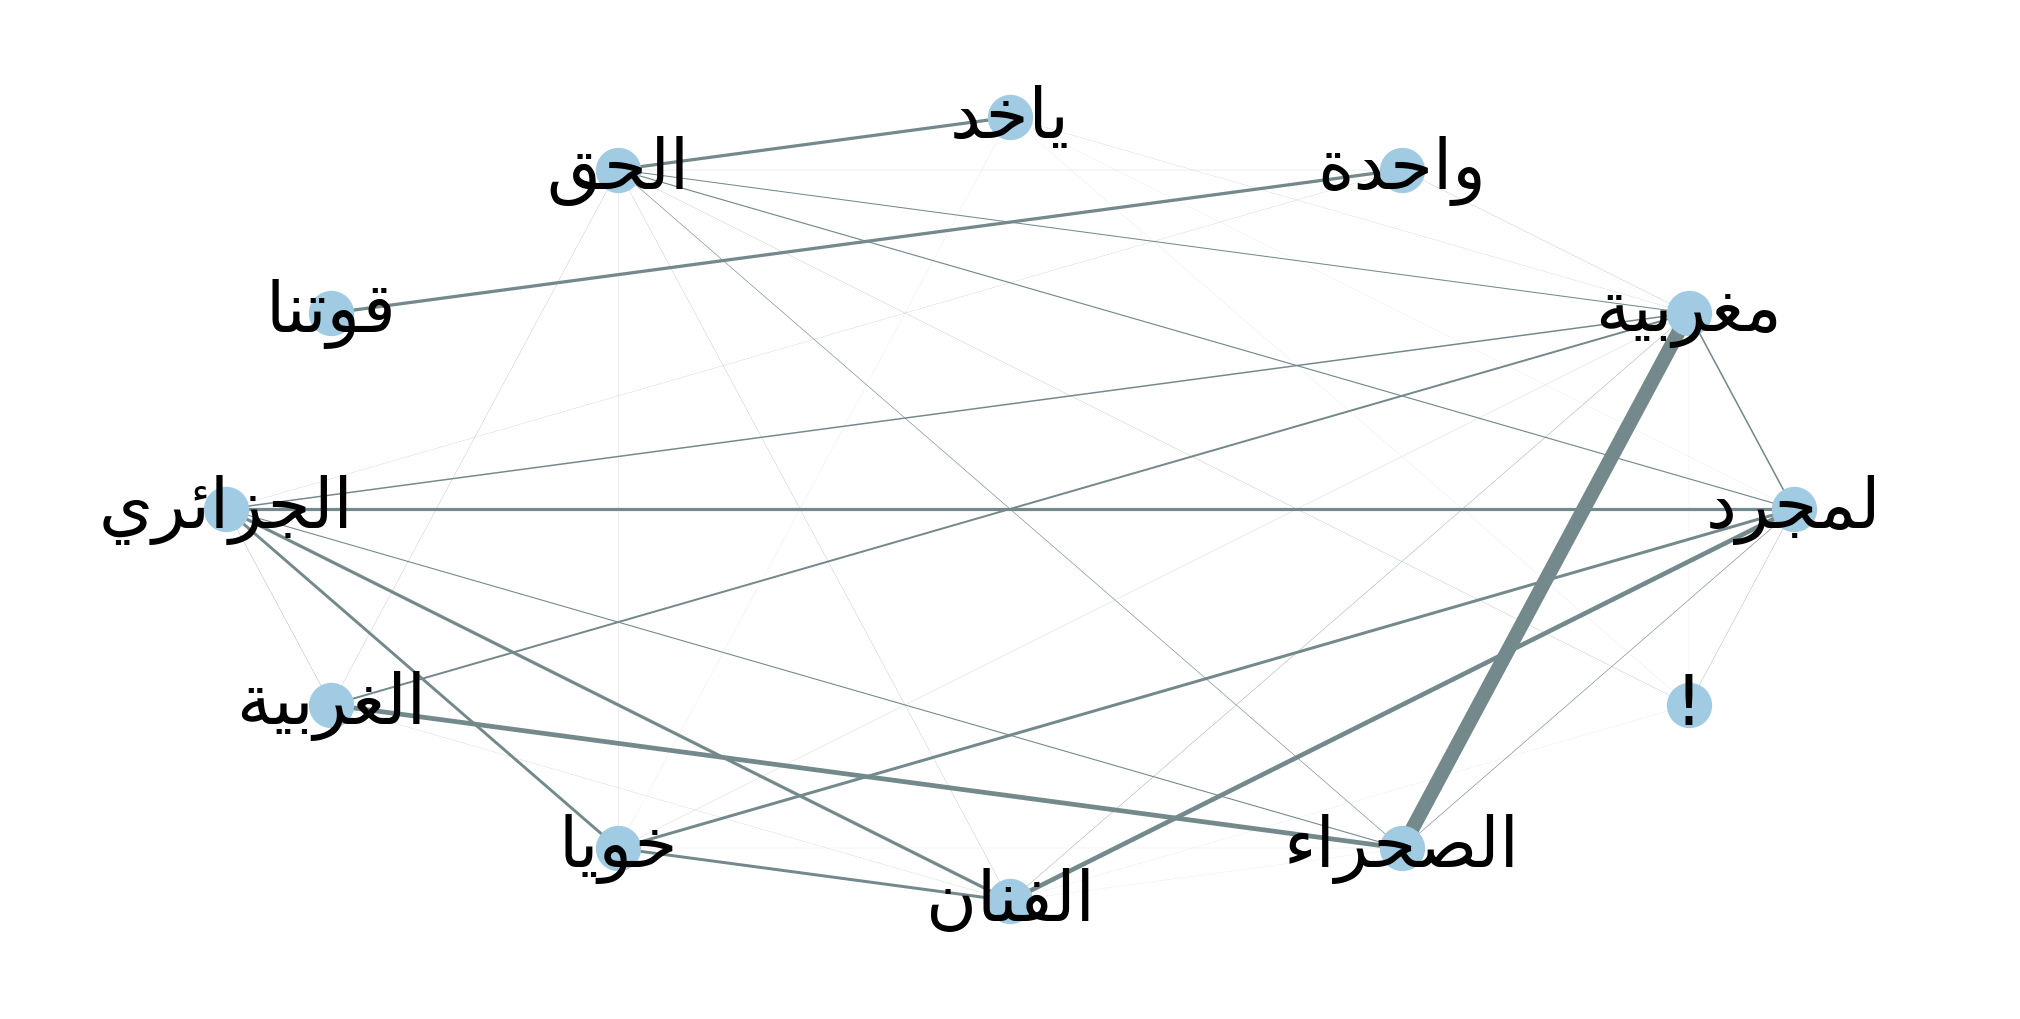

topic: T3


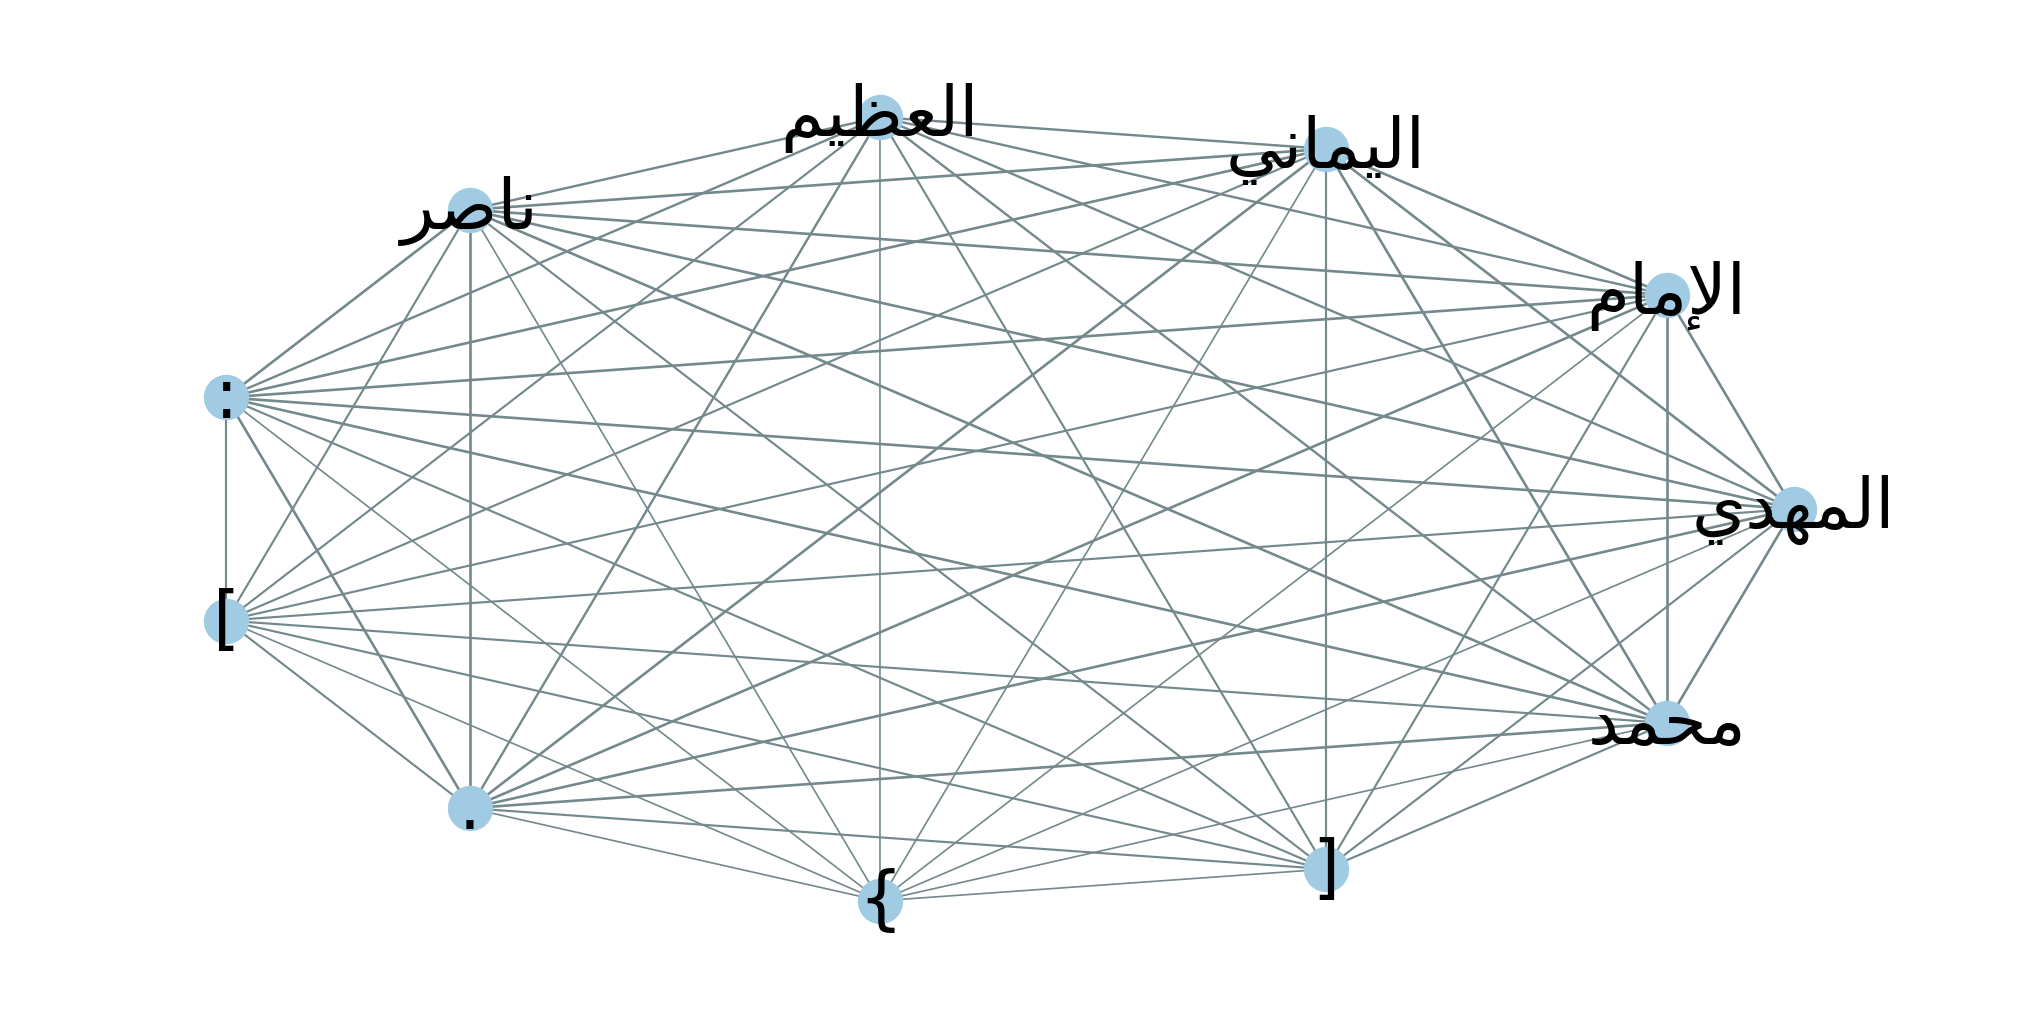

topic: T4


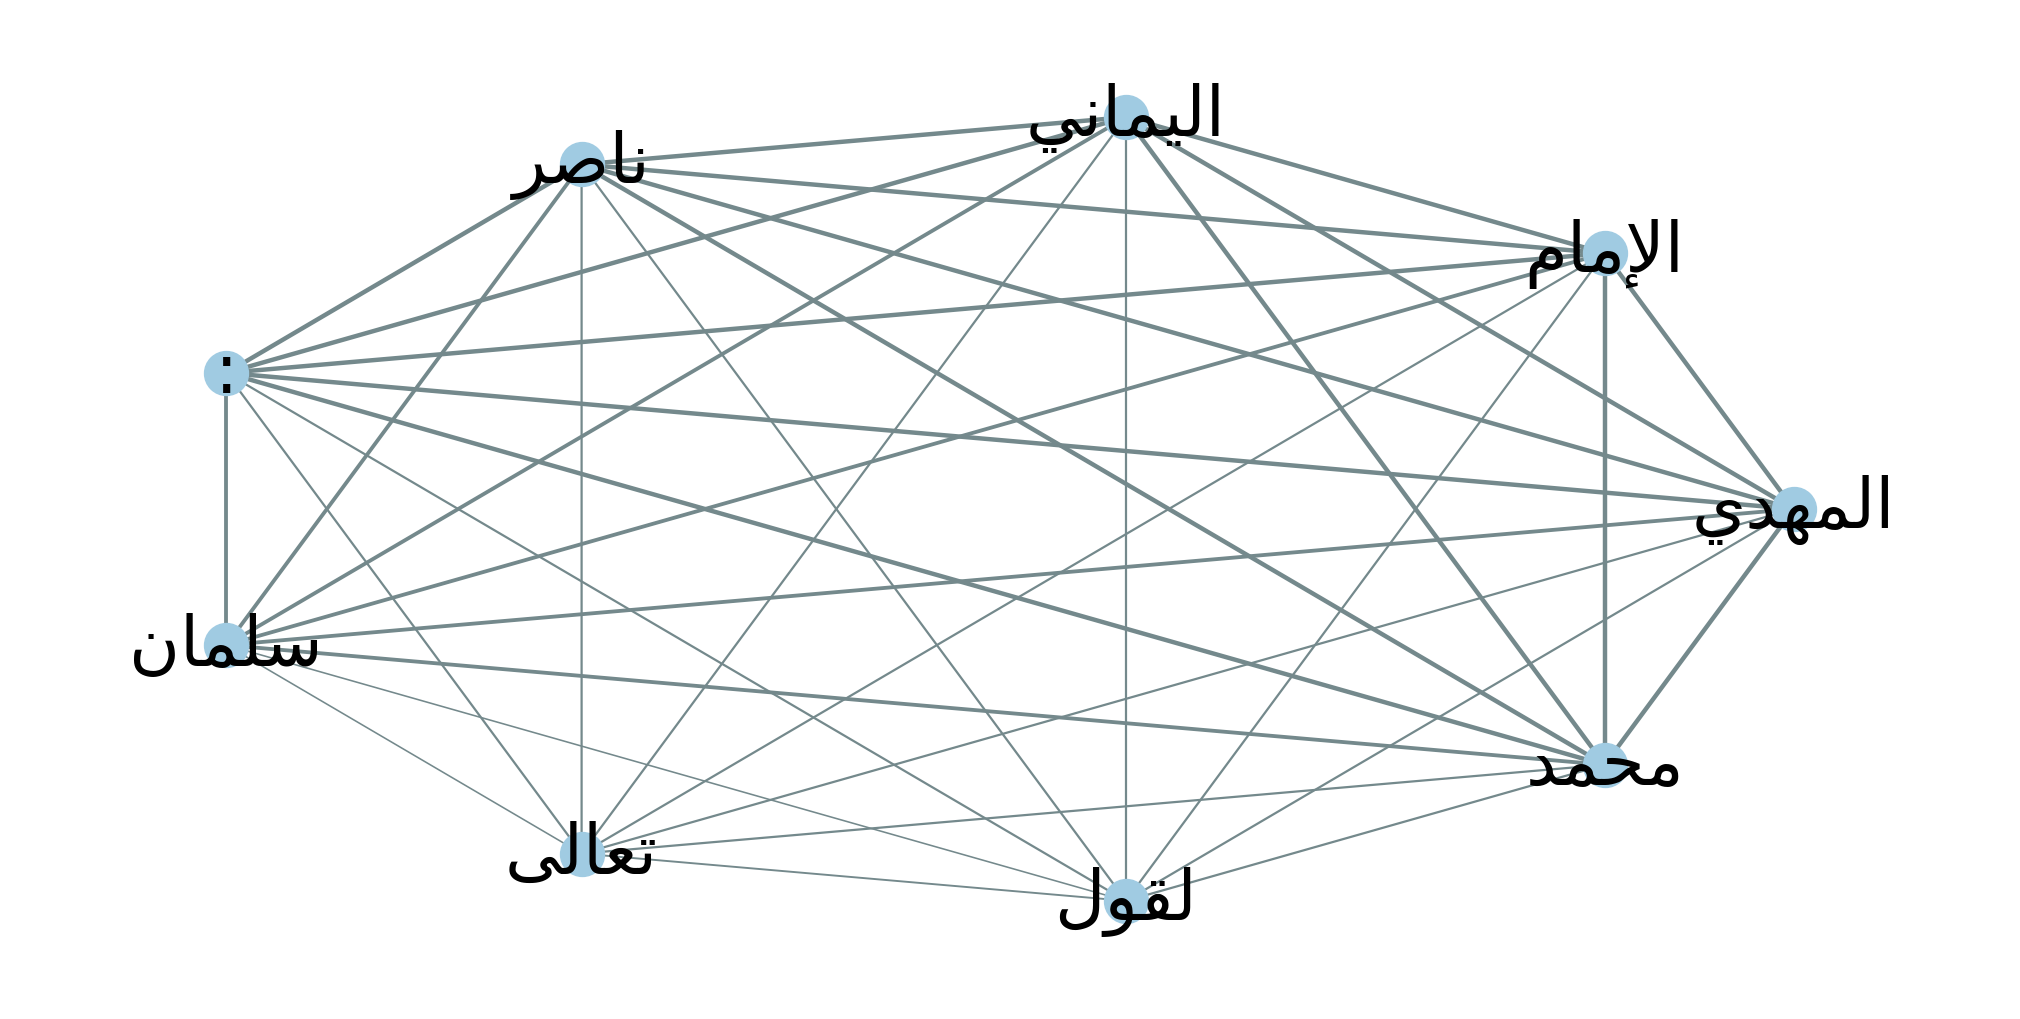

In [202]:
for topic in topics:
    print("topic:",topic)
    #if (topic == "Social Life"):
    stemmed_text_list = result_df[result_df["cluster"] == topic]["comment"]
    stemmed_text_list=remove_stopwords(stemmed_text_list, most_commonWords)
    tokens_tfd,top_20_tokens = get_tokens_tfd(stemmed_text_list,6)
    plot_graph(topic,stemmed_text_list, top_20_tokens, tokens_tfd)

Cross-Validation Scores: [0.68421053 0.63397129 0.66426859 0.68585132 0.62110312]
Mean CV Accuracy: 0.6578809679529104
Accuracy: 0.7068965517241379
Precision: 0.7189775057709166
Recall: 0.7068965517241379
F1-Score: 0.7108718944815381


<Figure size 1200x600 with 0 Axes>

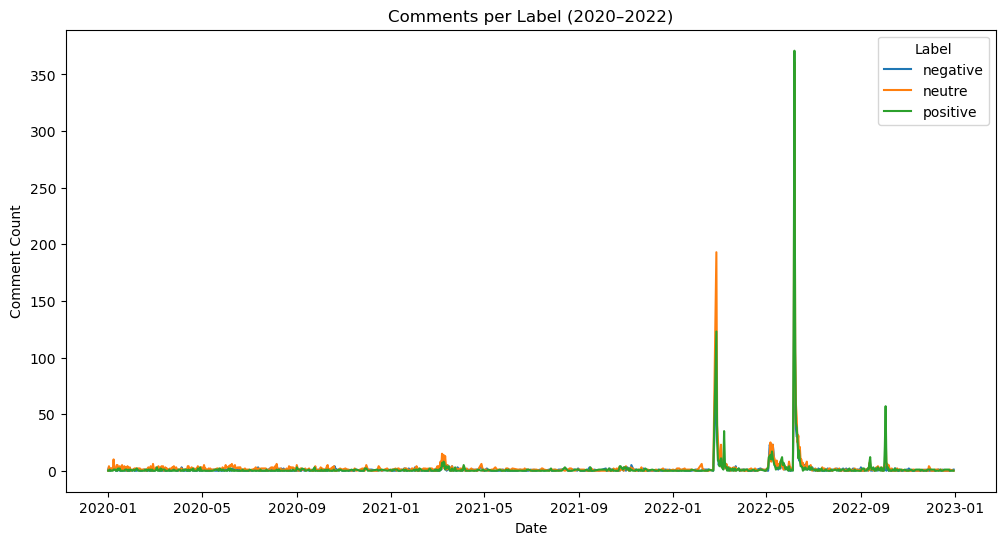

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

# ============================
# Load datasets
# ============================
df = pd.read_excel('1700clean.xlsx')
df2 = pd.read_excel('datasets.xlsx')

# ============================
# Clean and normalize labels
# ============================
df['Avis'] = df['Avis'].astype(str).str.strip().str.lower()

# Fix common typos manually
df['Avis'] = df['Avis'].replace({
    'positve': 'positive',
    'postive': 'positive',
    'negetive': 'negative',
    'neagtive': 'negative',
    'nutral': 'neutral'
})

# Extract columns
comments = df['cleaned_comment'].replace(np.nan, '', regex=True)
labels = df['Avis']
comments_ = df2['cleaned_comment']

# ============================
# Train/test split
# ============================
train_comments, test_comments, train_labels, test_labels = train_test_split(
    comments, labels, test_size=0.2, random_state=48
)

# ============================
# TF-IDF + SVM
# ============================
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_comments)
test_tfidf = tfidf_vectorizer.transform(test_comments)

model = SVC(kernel='linear', class_weight='balanced', random_state=50)

# Cross-validation
cv_scores = cross_val_score(model, train_tfidf, train_labels, cv=5)

# Train
model.fit(train_tfidf, train_labels)

# Predict test set
predictions = model.predict(test_tfidf)

# ============================
# Evaluation
# ============================
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# ============================
# Predictions on df2
# ============================
tfidf_matrix = tfidf_vectorizer.transform(comments_)
predictions = model.predict(tfidf_matrix)

# Create results dataframe
result_df = pd.DataFrame({'comment': comments_, 'label': predictions})

# Add timestamp column
result_df['timestamp'] = pd.to_datetime(df2['timestamp'], errors='coerce', utc=True)

# ============================
# Filter between 2020 and 2022
# ============================
start_date = pd.Timestamp("2020-01-01", tz='UTC')
end_date = pd.Timestamp("2022-12-31", tz='UTC')

result_df = result_df[
    (result_df['timestamp'] >= start_date) & 
    (result_df['timestamp'] <= end_date)
]

# ============================
# Group + Plot
# ============================
counts = result_df.groupby([result_df['timestamp'].dt.date, 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
counts.plot(kind='line', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Comment Count')
plt.title('Comments per Label (2020–2022)')
plt.legend(title='Label')
plt.show()
